In [124]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (roc_auc_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, balanced_accuracy_score, average_precision_score)


#load database
df=pd.read_csv("risk_factors_cervical_cancer.csv")
print(df)

     Age Number of sexual partners First sexual intercourse  \
0     18                       4.0                     15.0   
1     15                       1.0                     14.0   
2     34                       1.0                        ?   
3     52                       5.0                     16.0   
4     46                       3.0                     21.0   
..   ...                       ...                      ...   
853   34                       3.0                     18.0   
854   32                       2.0                     19.0   
855   25                       2.0                     17.0   
856   33                       2.0                     24.0   
857   29                       2.0                     20.0   

    Num of pregnancies Smokes Smokes (years) Smokes (packs/year)  \
0                  1.0    0.0            0.0                 0.0   
1                  1.0    0.0            0.0                 0.0   
2                  1.0    0.0          

In [125]:
#replace ? with nan and then convert to numeric
df=df.replace("?", np.nan)
df=df.apply(pd.to_numeric, errors="coerce")#in case cannot be converted, replace with nan
df.info()
print("\n")
missingRatio = df.isna().mean().sort_values(ascending=False)
print(missingRatio)

#drop columns with too many missing values
df = df.drop(columns=["STDs: Time since first diagnosis", "STDs: Time since last diagnosis"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 858 non-null    int64  
 1   Number of sexual partners           832 non-null    float64
 2   First sexual intercourse            851 non-null    float64
 3   Num of pregnancies                  802 non-null    float64
 4   Smokes                              845 non-null    float64
 5   Smokes (years)                      845 non-null    float64
 6   Smokes (packs/year)                 845 non-null    float64
 7   Hormonal Contraceptives             750 non-null    float64
 8   Hormonal Contraceptives (years)     750 non-null    float64
 9   IUD                                 741 non-null    float64
 10  IUD (years)                         741 non-null    float64
 11  STDs                                753 non-n

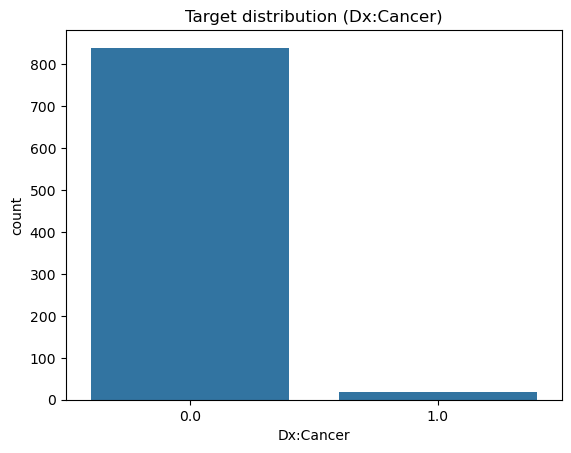

Dx:Cancer
0.0    0.979021
1.0    0.020979
Name: proportion, dtype: float64

In [126]:
#binary(bool) columns imputation
binaryCols=[c for c in df.columns if df[c].dropna().isin([0,1]).all()]
binaryImputer=SimpleImputer(strategy="most_frequent")
df[binaryCols]=binaryImputer.fit_transform(df[binaryCols])

#continuous or discrete non binary columns imputation
continuousCols=list(set(df.columns)-set(binaryCols))
numericalImputer=SimpleImputer(strategy="median")
df[continuousCols]=numericalImputer.fit_transform(df[continuousCols])

#Dx:Cancer distribution
sns.countplot(x=df["Dx:Cancer"])
plt.title("Target distribution (Dx:Cancer)")
plt.show()
df["Dx:Cancer"].value_counts(normalize=True)


In [127]:
# Target vs features
y=df["Dx:Cancer"]
X=df.drop("Dx:Cancer", axis=1)

print("Target class distribution:")
print(y.value_counts())
print(y.value_counts(normalize=True))

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,stratify=y,random_state=42)


Target class distribution:
Dx:Cancer
0.0    840
1.0     18
Name: count, dtype: int64
Dx:Cancer
0.0    0.979021
1.0    0.020979
Name: proportion, dtype: float64


In [128]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [129]:
results=[]

def testModel(y_true, y_pred, y_prob, method_name):
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    # Metrics
    prec=precision_score(y_true, y_pred, zero_division=0)
    rec=recall_score(y_true, y_pred)
    f1=f1_score(y_true, y_pred)
    balAcc=balanced_accuracy_score(y_true, y_pred)
    roc=roc_auc_score(y_true, y_prob)
    ap=average_precision_score(y_true, y_prob)

    print("Precision (positive class):", prec)
    print("Recall (positive class):", rec)
    print("F1-score (positive class):", f1)
    print("Balanced Accuracy:", balAcc)
    print("ROC AUC:", roc)
    print("Average Precision (PR AUC):", ap)

    # --- Log results ---
    if method_name is not None:
        results.append({
            "method": method_name,
            "AUC": roc,
            "Accuracy": (cm[0,0] + cm[1,1]) / cm.sum(),
            "Balanced Accuracy": balAcc,
            "Precision": prec,
            "Recall": rec,
            "F1": f1,
            "PR AUC": ap
        })

In [130]:
models = {
    "LogReg": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced"),
    "SVM": SVC(kernel="rbf", probability=True, class_weight="balanced")
}

for name, m in models.items():
    m.fit(X_train_scaled, y_train)
    y_pred = m.predict(X_test_scaled)
    y_prob = m.predict_proba(X_test_scaled)[:, 1]
    print("\n")
    print(name)
    testModel(y_test, y_pred, y_prob, name)



LogReg
Confusion Matrix:
 [[208   2]
 [  0   5]]
Precision (positive class): 0.7142857142857143
Recall (positive class): 1.0
F1-score (positive class): 0.8333333333333334
Balanced Accuracy: 0.9952380952380953
ROC AUC: 0.9961904761904762
Average Precision (PR AUC): 0.8528571428571428


RandomForest
Confusion Matrix:
 [[209   1]
 [  1   4]]
Precision (positive class): 0.8
Recall (positive class): 0.8
F1-score (positive class): 0.8
Balanced Accuracy: 0.8976190476190476
ROC AUC: 0.9952380952380953
Average Precision (PR AUC): 0.71


SVM
Confusion Matrix:
 [[209   1]
 [  1   4]]
Precision (positive class): 0.8
Recall (positive class): 0.8
F1-score (positive class): 0.8
Balanced Accuracy: 0.8976190476190476
ROC AUC: 0.9933333333333333
Average Precision (PR AUC): 0.6683333333333333


In [131]:
# Random Forest feature importance
rf = models["RandomForest"]
feat_imp = pd.Series(rf.feature_importances_, index=X.columns)
feat_imp = feat_imp.sort_values(ascending=False)
print("\nTop 10 important features:")
print(feat_imp.head(10))


Top 10 important features:
Dx:HPV                             0.277922
Dx                                 0.203066
Age                                0.112217
First sexual intercourse           0.078603
IUD (years)                        0.055558
Hormonal Contraceptives (years)    0.054017
IUD                                0.033993
Schiller                           0.026503
Biopsy                             0.025477
Number of sexual partners          0.022906
dtype: float64


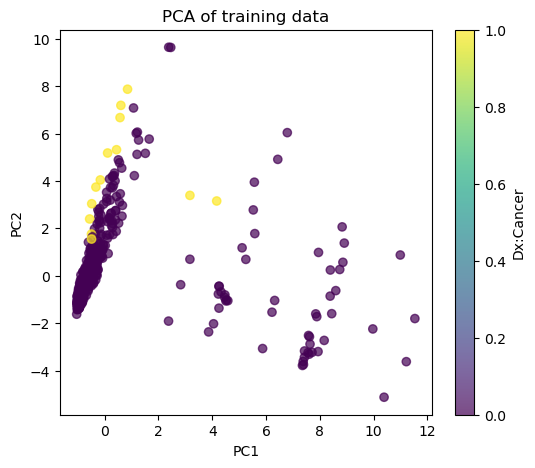

Explained variance: [0.15605075 0.09313169]


In [132]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train, alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of training data")
plt.colorbar(label="Dx:Cancer")
plt.show()

print("Explained variance:", pca.explained_variance_ratio_)

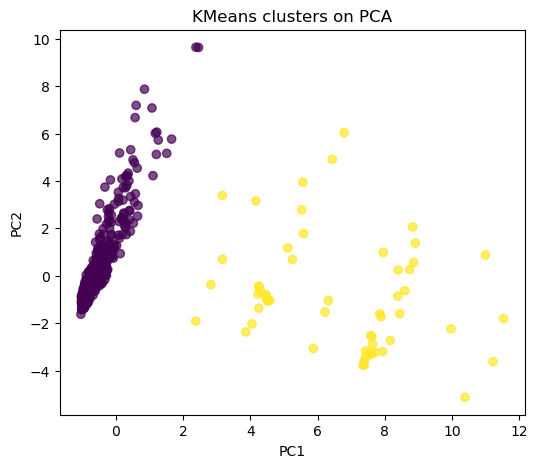

In [133]:
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_train_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=clusters, alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans clusters on PCA")
plt.show()

In [134]:
corrs = df.corr()["Dx:Cancer"].sort_values()
print("\nCorrelations with Dx:Cancer:")
print(corrs)


Correlations with Dx:Cancer:
STDs:condylomatosis                  -0.034034
STDs:vulvo-perineal condylomatosis   -0.033624
STDs:syphilis                        -0.021429
STDs:HIV                             -0.021429
STDs: Number of diagnosis            -0.015423
Dx:CIN                               -0.015072
Smokes                               -0.013470
STDs (number)                        -0.012141
STDs:vaginal condylomatosis          -0.010018
STDs:Hepatitis B                     -0.005000
STDs:genital herpes                  -0.005000
STDs:pelvic inflammatory disease     -0.005000
STDs:molluscum contagiosum           -0.005000
STDs                                  0.009638
Hormonal Contraceptives               0.011278
Number of sexual partners             0.023699
Num of pregnancies                    0.036962
Smokes (years)                        0.052859
Hormonal Contraceptives (years)       0.062971
First sexual intercourse              0.067281
IUD (years)                   

In [135]:
lr_pca = LogisticRegression(class_weight="balanced")
lr_pca.fit(X_train_pca, y_train)
y_pred_pca = lr_pca.predict(X_test_pca)
y_prob_pca = lr_pca.predict_proba(X_test_pca)[:,1]

print("\nLogReg on PCA features")
testModel(y_test, y_pred_pca, y_prob_pca, "LogReg on PCA")


LogReg on PCA features
Confusion Matrix:
 [[188  22]
 [  0   5]]
Precision (positive class): 0.18518518518518517
Recall (positive class): 1.0
F1-score (positive class): 0.3125
Balanced Accuracy: 0.9476190476190476
ROC AUC: 0.98
Average Precision (PR AUC): 0.7253588516746412


In [136]:
test_feats = ["Hinselmann", "Schiller", "Citology", "Biopsy"]
X_testonly = df[test_feats]

Xt_train, Xt_test, yt_train, yt_test = train_test_split(
    X_testonly, y, test_size=0.25, stratify=y, random_state=42
)

Xt_train_scaled = scaler.fit_transform(Xt_train)
Xt_test_scaled = scaler.transform(Xt_test)

lr_tests = LogisticRegression(class_weight="balanced")
lr_tests.fit(Xt_train_scaled, yt_train)
yt_pred = lr_tests.predict(Xt_test_scaled)
yt_prob = lr_tests.predict_proba(Xt_test_scaled)[:,1]

print("\nLogReg with only screening tests")
testModel(yt_test, yt_pred, yt_prob, "LogReg Screening")


LogReg with only screening tests
Confusion Matrix:
 [[187  23]
 [  2   3]]
Precision (positive class): 0.11538461538461539
Recall (positive class): 0.6
F1-score (positive class): 0.1935483870967742
Balanced Accuracy: 0.7452380952380953
ROC AUC: 0.7519047619047619
Average Precision (PR AUC): 0.1187467700258398


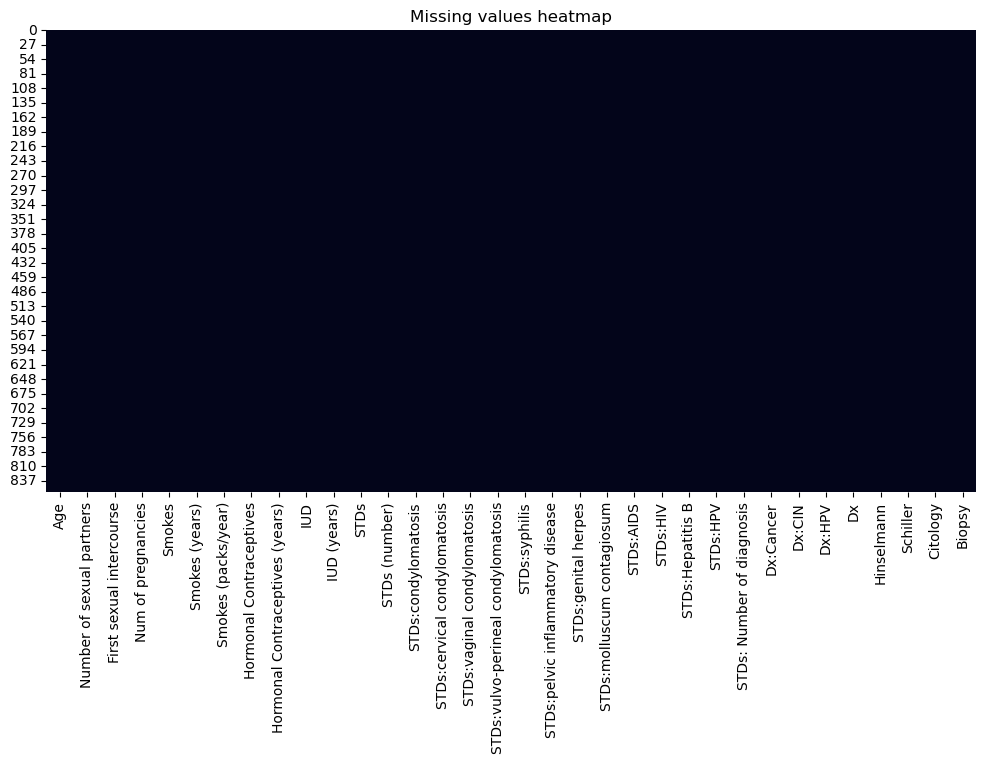

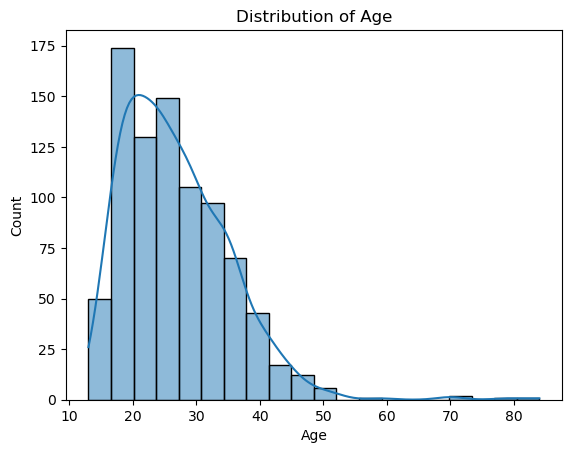

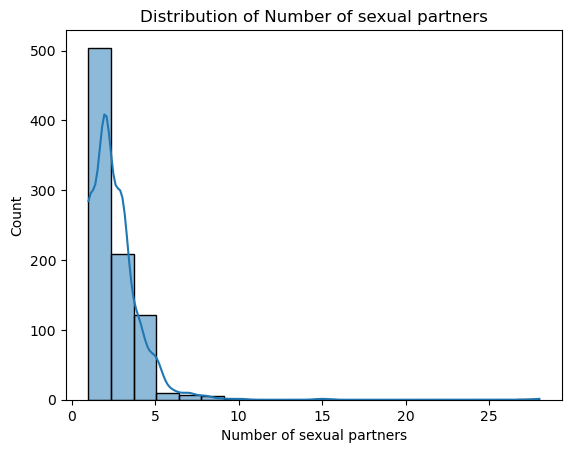

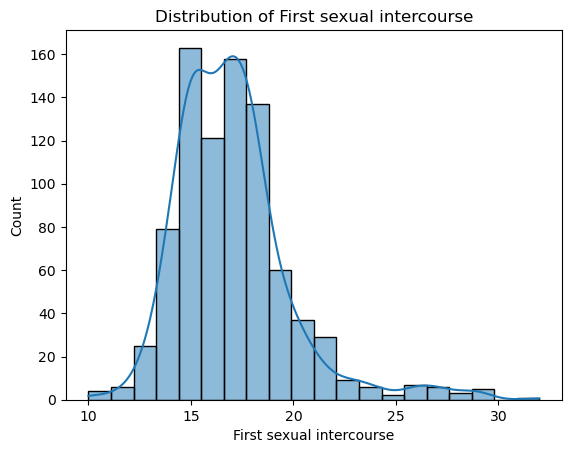

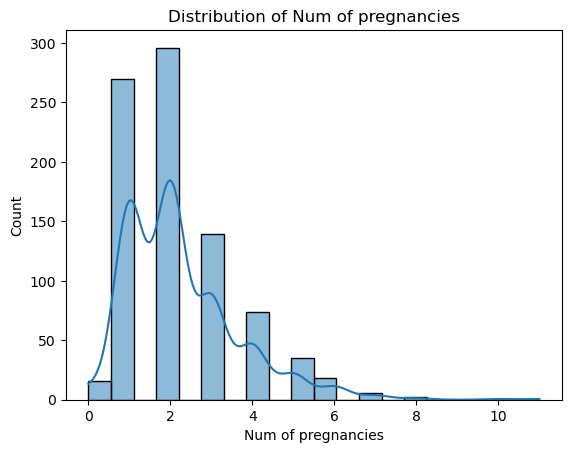

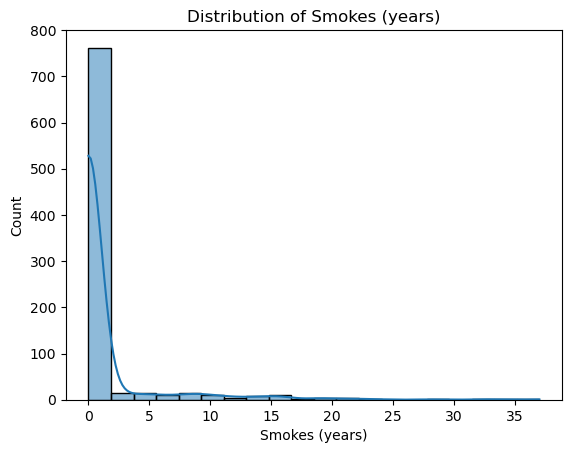

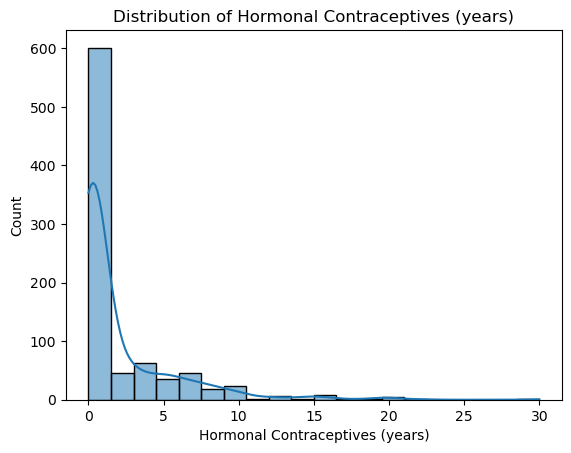

In [137]:
# Missing values heatmap
plt.figure(figsize=(12,6))
sns.heatmap(df.isna(), cbar=False)
plt.title("Missing values heatmap")
plt.show()

# Numeric distributions
num_feats = ["Age", "Number of sexual partners", "First sexual intercourse",
             "Num of pregnancies", "Smokes (years)", "Hormonal Contraceptives (years)"]

for f in num_feats:
    plt.figure()
    sns.histplot(df[f], bins=20, kde=True)
    plt.title(f"Distribution of {f}")
    plt.show()

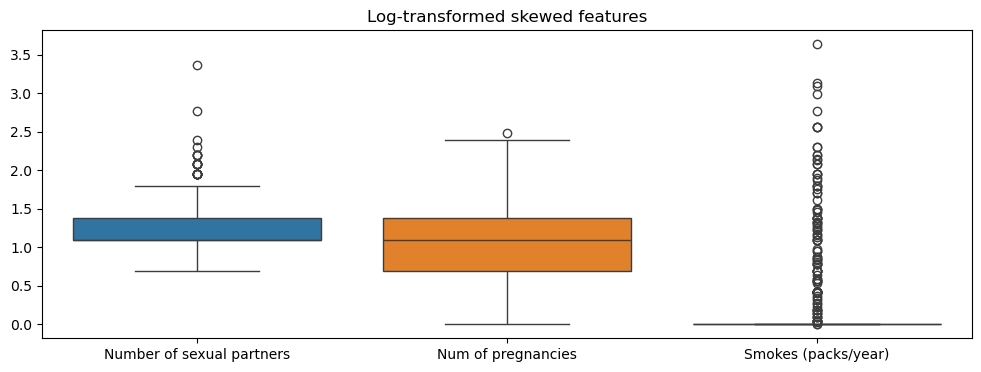

In [138]:
skewed = ["Number of sexual partners", "Num of pregnancies", "Smokes (packs/year)"]
df_log = df.copy()
for f in skewed:
    df_log[f] = np.log1p(df_log[f])

plt.figure(figsize=(12,4))
sns.boxplot(data=df_log[skewed])
plt.title("Log-transformed skewed features")
plt.show()

In [139]:
# MinMax scaling
scaler_mm = MinMaxScaler()
X_train_mm = scaler_mm.fit_transform(X_train)
X_test_mm = scaler_mm.transform(X_test)
print("MinMax scaled sample features:")
print(X_train_mm[:5])

# KNN imputation
knn_imp = KNNImputer(n_neighbors=5)
df_knn = pd.DataFrame(knn_imp.fit_transform(df), columns=df.columns)
print("\nMissing values after KNN imputation:")
print(df_knn.isna().sum())

MinMax scaled sample features:
[[0.08450704 0.14285714 0.26315789 0.18181818 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.26760563 0.14285714 0.42105263 0.18181818 0.         0.
  0.         1.         0.26666667 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.32394366 0.         0.31578947 0.27272727 0.         0.
  0.         1.         0.36666667 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         

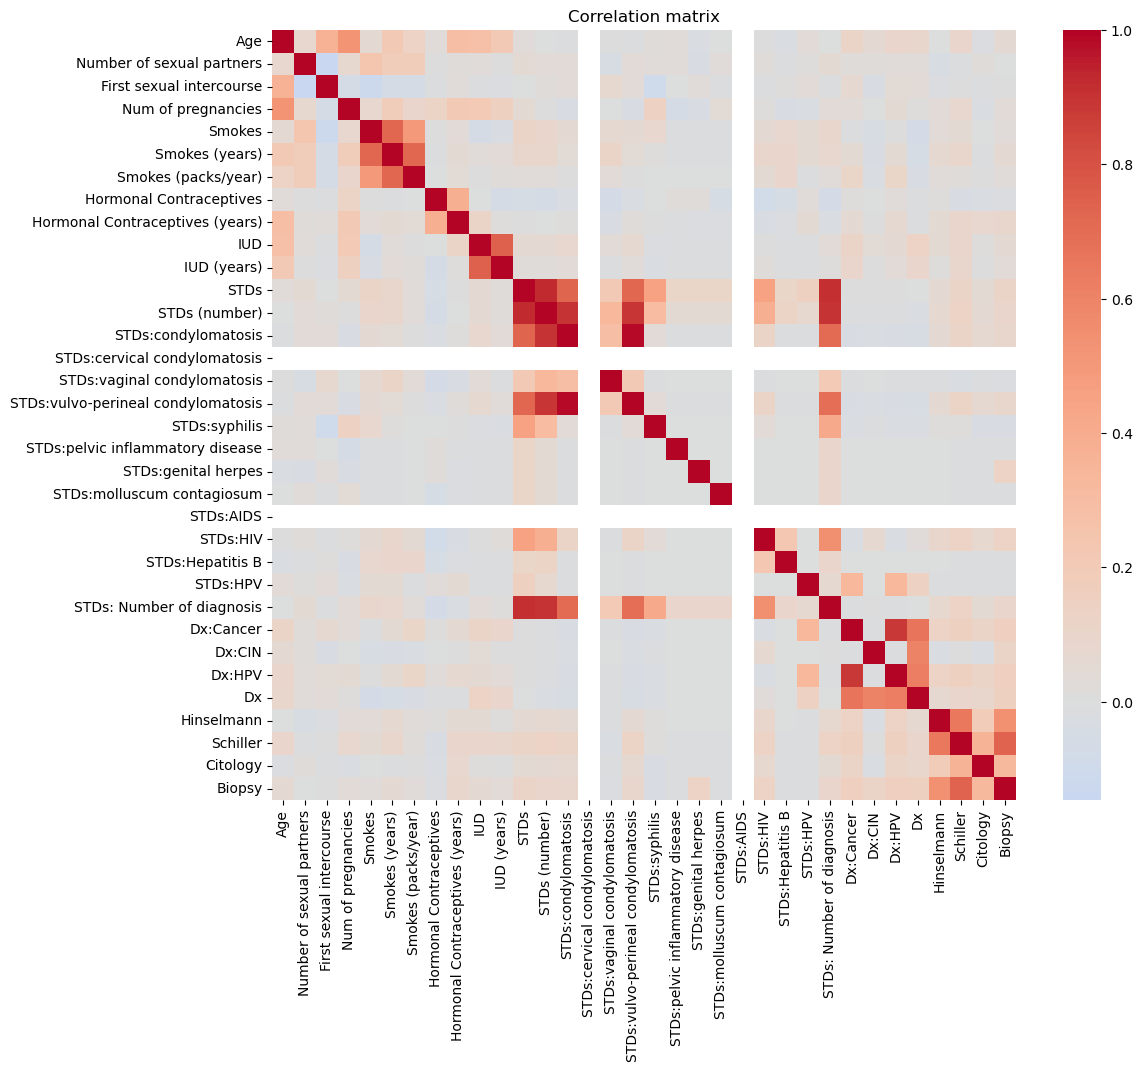

In [140]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap="coolwarm", center=0)
plt.title("Correlation matrix")
plt.show()


In [141]:
gb = GradientBoostingClassifier(n_estimators=300, random_state=42)
gb.fit(X_train_scaled, y_train)
y_pred_gb = gb.predict(X_test_scaled)
y_prob_gb = gb.predict_proba(X_test_scaled)[:,1]

print("\nGradient Boosting results")
testModel(y_test, y_pred_gb, y_prob_gb, "Gradient Boost")


Gradient Boosting results
Confusion Matrix:
 [[208   2]
 [  0   5]]
Precision (positive class): 0.7142857142857143
Recall (positive class): 1.0
F1-score (positive class): 0.8333333333333334
Balanced Accuracy: 0.9952380952380953
ROC AUC: 0.9966666666666667
Average Precision (PR AUC): 0.7828571428571429


In [142]:
cv_scores = cross_val_score(
    LogisticRegression(max_iter=1000, class_weight="balanced"),
    X_train_scaled, y_train, cv=5, scoring="roc_auc"
)
print("\nLogReg 5-fold CV ROC AUC:", cv_scores)
print("Mean:", cv_scores.mean())



LogReg 5-fold CV ROC AUC: [1. 1. 1. 1. 1.]
Mean: 1.0


In [143]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_scaled, y_train)
print("\nAfter SMOTE class distribution:")
print(pd.Series(y_train_sm).value_counts())

lr_sm = LogisticRegression(max_iter=1000)
lr_sm.fit(X_train_sm, y_train_sm)
y_pred_sm = lr_sm.predict(X_test_scaled)
y_prob_sm = lr_sm.predict_proba(X_test_scaled)[:,1]

print("\nLogReg with SMOTE")
testModel(y_test, y_pred_sm, y_prob_sm, "LogReg SMOTE")




After SMOTE class distribution:
Dx:Cancer
0.0    630
1.0    630
Name: count, dtype: int64

LogReg with SMOTE
Confusion Matrix:
 [[208   2]
 [  0   5]]
Precision (positive class): 0.7142857142857143
Recall (positive class): 1.0
F1-score (positive class): 0.8333333333333334
Balanced Accuracy: 0.9952380952380953
ROC AUC: 0.9961904761904762
Average Precision (PR AUC): 0.8528571428571428


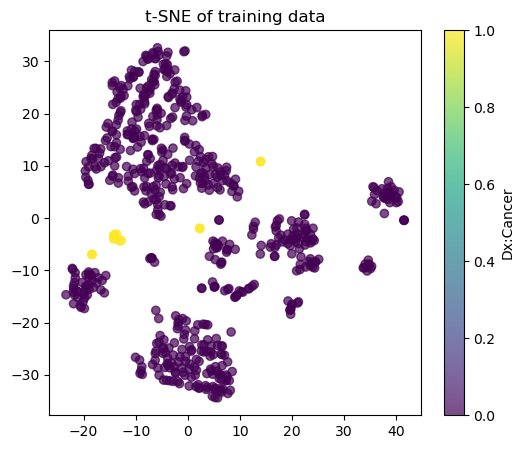

In [144]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_train_tsne = tsne.fit_transform(X_train_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_train_tsne[:,0], X_train_tsne[:,1], c=y_train, alpha=0.7)
plt.title("t-SNE of training data")
plt.colorbar(label="Dx:Cancer")
plt.show()


In [145]:
sel = SelectKBest(score_func=f_classif, k=10)
X_top = sel.fit_transform(X_train_scaled, y_train)
top_feats = X_train.columns[sel.get_support()]
print("\nTop 10 features by ANOVA F-test:")
print(top_feats)

lr_fs = LogisticRegression(class_weight="balanced", max_iter=1000)
lr_fs.fit(X_train_scaled[:, sel.get_support()], y_train)
y_pred_fs = lr_fs.predict(X_test_scaled[:, sel.get_support()])
y_prob_fs = lr_fs.predict_proba(X_test_scaled[:, sel.get_support()])[:,1]
print("\nLogReg on top features")
testModel(y_test, y_pred_fs, y_prob_fs, "LogRegTop10")


Top 10 features by ANOVA F-test:
Index(['Age', 'Hormonal Contraceptives (years)', 'IUD', 'IUD (years)',
       'STDs:HPV', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller', 'Biopsy'],
      dtype='object')

LogReg on top features
Confusion Matrix:
 [[207   3]
 [  0   5]]
Precision (positive class): 0.625
Recall (positive class): 1.0
F1-score (positive class): 0.7692307692307693
Balanced Accuracy: 0.9928571428571429
ROC AUC: 0.9961904761904762
Average Precision (PR AUC): 0.885


In [146]:
# baseline
X_base = df.drop("Dx:Cancer", axis=1)
y_base = df["Dx:Cancer"]
Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    X_base, y_base, test_size=0.25, stratify=y_base, random_state=42
)
scaler = StandardScaler()
Xb_train = scaler.fit_transform(Xb_train)
Xb_test = scaler.transform(Xb_test)
lr = LogisticRegression(max_iter=1000, class_weight="balanced")
lr.fit(Xb_train, yb_train)
yb_pred = lr.predict(Xb_test)
yb_prob = lr.predict_proba(Xb_test)[:, 1]
print("\nBaseline Logistic Regression")
testModel(yb_test, yb_pred, yb_prob, "Logistic Regression")

# log-transformed
X_log = df_log.drop("Dx:Cancer", axis=1)
y_log = df_log["Dx:Cancer"]
Xl_train, Xl_test, yl_train, yl_test = train_test_split(
    X_log, y_log, test_size=0.25, stratify=y_log, random_state=42
)
Xl_train = scaler.fit_transform(Xl_train)
Xl_test = scaler.transform(Xl_test)
lr_log = LogisticRegression(max_iter=1000, class_weight="balanced")
lr_log.fit(Xl_train, yl_train)
yl_pred = lr.predict(Xl_test)
yl_prob = lr_log.predict_proba(Xl_test)[:, 1]

print("\nLogReg on log-transformed features")
testModel(yl_test, yl_pred, yl_prob, "LogReg on log-transformed")


Baseline Logistic Regression
Confusion Matrix:
 [[208   2]
 [  0   5]]
Precision (positive class): 0.7142857142857143
Recall (positive class): 1.0
F1-score (positive class): 0.8333333333333334
Balanced Accuracy: 0.9952380952380953
ROC AUC: 0.9961904761904762
Average Precision (PR AUC): 0.8528571428571428

LogReg on log-transformed features
Confusion Matrix:
 [[208   2]
 [  0   5]]
Precision (positive class): 0.7142857142857143
Recall (positive class): 1.0
F1-score (positive class): 0.8333333333333334
Balanced Accuracy: 0.9952380952380953
ROC AUC: 0.9961904761904762
Average Precision (PR AUC): 0.8528571428571428


In [147]:
# Cross-Modality Sign-Transfer Evaluation (predict both target modality and Dx:Cancer)

from scipy.special import expit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

modalities = ["Hinselmann", "Schiller", "Citology", "Biopsy"]

# --- Loss + gradient for sign-transfer ---
def sign_transfer_loss_grad(w, X, y, w_src, alpha=0.8, l2=1e-3):
    n = X.shape[0]
    y_pred = expit(X @ w)
    
    loss_log = -np.mean(y*np.log(y_pred+1e-10) + (1-y)*np.log(1-y_pred+1e-10))
    sign_agreement = np.maximum(0, -w*np.sign(w_src))
    loss_sign = alpha * np.sum(sign_agreement**2)
    loss_l2 = (1-alpha)*l2*np.sum(w**2)
    
    loss = loss_log + loss_sign + loss_l2
    grad = X.T @ (y_pred - y)/n + alpha*2*sign_agreement*(-np.sign(w_src)) + (1-alpha)*2*l2*w
    return loss, grad

def train_sign_transfer(X, y, w_src, alpha=0.8, l2=1e-3, lr=0.1, epochs=500):
    w = np.zeros(X.shape[1])
    for _ in range(epochs):
        _, grad = sign_transfer_loss_grad(w, X, y, w_src, alpha, l2)
        w -= lr*grad
    return w

# --- Store cross-modality gains ---
transfer_gains = pd.DataFrame(index=modalities, columns=modalities, dtype=float)

for src_mod in modalities:
    idx_src = df[src_mod].notna()
    if idx_src.sum() == 0:
        continue

    # Source features and target modality
    X_src = df.loc[idx_src].drop(columns=modalities)
    y_src = df.loc[idx_src, src_mod].values

    lr_src = LogisticRegression(max_iter=1000, class_weight="balanced")
    lr_src.fit(X_src, y_src)
    w_src = lr_src.coef_.flatten()

    for tgt_mod in modalities:
        idx_tgt = df[tgt_mod].notna()
        if idx_tgt.sum() == 0:
            transfer_gains.loc[src_mod, tgt_mod] = np.nan
            continue

        y_tgt_mod = df.loc[idx_tgt, tgt_mod].values
        if len(np.unique(y_tgt_mod)) < 2:
            print(f"Skipping {src_mod} -> {tgt_mod} (target has only one class)")
            transfer_gains.loc[src_mod, tgt_mod] = np.nan
            continue

        X_tgt = df.loc[idx_tgt].drop(columns=modalities)

        # --- Target with sign-transfer ---
        w_tgt = train_sign_transfer(X_tgt, y_tgt_mod, w_src)
        y_prob_mod = expit(X_tgt @ w_tgt)
        y_pred_mod = (y_prob_mod >= 0.5).astype(int)

        # --- Evaluate on target modality ---
        print(f"\nSign-Transfer Results: Source={src_mod} -> Target={tgt_mod} (predicted modality)")
        testModel(y_tgt_mod, y_pred_mod, y_prob_mod, f"Sign-Transfer {src_mod}->{tgt_mod}")

        # --- Evaluate on actual cancer diagnosis ---
        y_true_cancer = df.loc[idx_tgt, "Dx:Cancer"].values
        print(f"\nSign-Transfer Results: Source={src_mod} -> Target={tgt_mod} (evaluated vs Dx:Cancer)")
        testModel(y_true_cancer, y_pred_mod, y_prob_mod, f"Sign-Transfer {src_mod}->cancer")

        # --- Baseline target-only model ---
        lr_tgt = LogisticRegression(max_iter=1000, class_weight="balanced")
        lr_tgt.fit(X_tgt, y_tgt_mod)
        y_prob_base = lr_tgt.predict_proba(X_tgt)[:,1]

        auc_base = roc_auc_score(y_true_cancer, y_prob_base)
        auc_transfer = roc_auc_score(y_true_cancer, y_prob_mod)
        gain_pct = 100*(auc_transfer - auc_base)/auc_base
        transfer_gains.loc[src_mod, tgt_mod] = gain_pct

print("\nCross-Modality Sign-Transfer Gains (% relative to target-only, evaluated vs Dx:Cancer):")
print(transfer_gains)



Sign-Transfer Results: Source=Hinselmann -> Target=Hinselmann (predicted modality)
Confusion Matrix:
 [[817   6]
 [ 33   2]]
Precision (positive class): 0.25
Recall (positive class): 0.05714285714285714
F1-score (positive class): 0.09302325581395349
Balanced Accuracy: 0.5249262280854018
ROC AUC: 0.6906960597118557
Average Precision (PR AUC): 0.10576140545771158

Sign-Transfer Results: Source=Hinselmann -> Target=Hinselmann (evaluated vs Dx:Cancer)
Confusion Matrix:
 [[832   8]
 [ 18   0]]
Precision (positive class): 0.0
Recall (positive class): 0.0
F1-score (positive class): 0.0
Balanced Accuracy: 0.49523809523809526
ROC AUC: 0.6462301587301588
Average Precision (PR AUC): 0.0448931457364859

Sign-Transfer Results: Source=Hinselmann -> Target=Schiller (predicted modality)
Confusion Matrix:
 [[784   0]
 [ 74   0]]
Precision (positive class): 0.0
Recall (positive class): 0.0
F1-score (positive class): 0.0
Balanced Accuracy: 0.5
ROC AUC: 0.4518839630446774
Average Precision (PR AUC): 0.08


Sign-Transfer Results: Source=Biopsy -> Target=Schiller (predicted modality)
Confusion Matrix:
 [[784   0]
 [ 74   0]]
Precision (positive class): 0.0
Recall (positive class): 0.0
F1-score (positive class): 0.0
Balanced Accuracy: 0.5
ROC AUC: 0.5362744760066188
Average Precision (PR AUC): 0.11801135760089293

Sign-Transfer Results: Source=Biopsy -> Target=Schiller (evaluated vs Dx:Cancer)
Confusion Matrix:
 [[840   0]
 [ 18   0]]
Precision (positive class): 0.0
Recall (positive class): 0.0
F1-score (positive class): 0.0
Balanced Accuracy: 0.5
ROC AUC: 0.426058201058201
Average Precision (PR AUC): 0.019724234540506272

Sign-Transfer Results: Source=Biopsy -> Target=Citology (predicted modality)
Confusion Matrix:
 [[814   0]
 [ 44   0]]
Precision (positive class): 0.0
Recall (positive class): 0.0
F1-score (positive class): 0.0
Balanced Accuracy: 0.5
ROC AUC: 0.5515412106321197
Average Precision (PR AUC): 0.06461017066458273

Sign-Transfer Results: Source=Biopsy -> Target=Citology (evalu

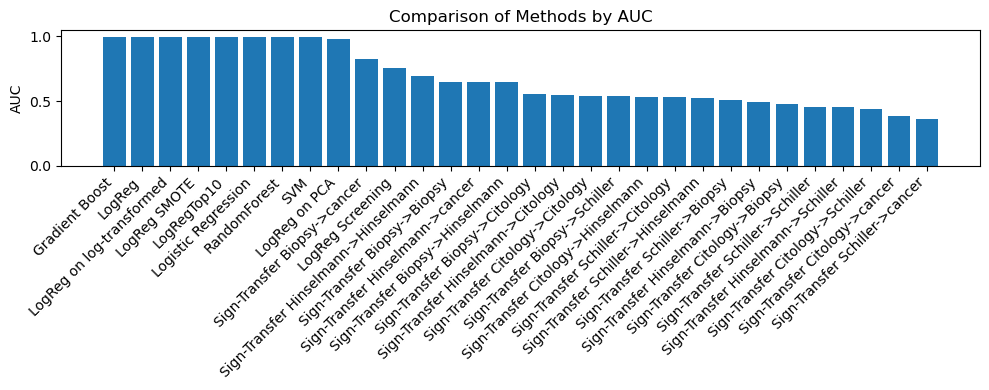

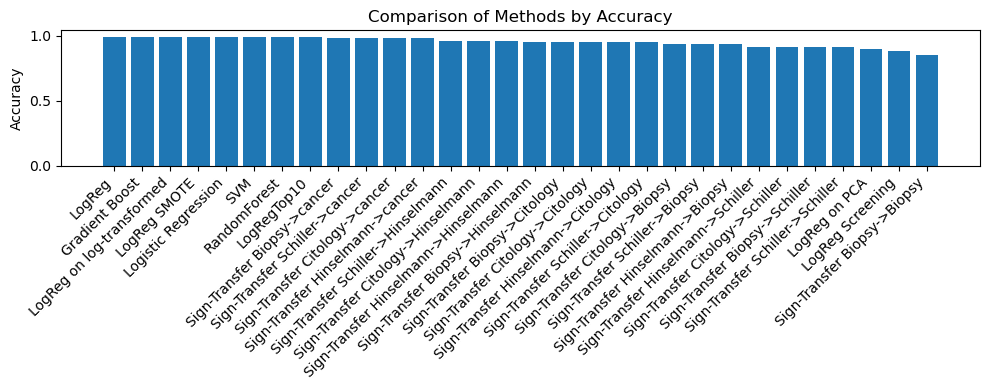

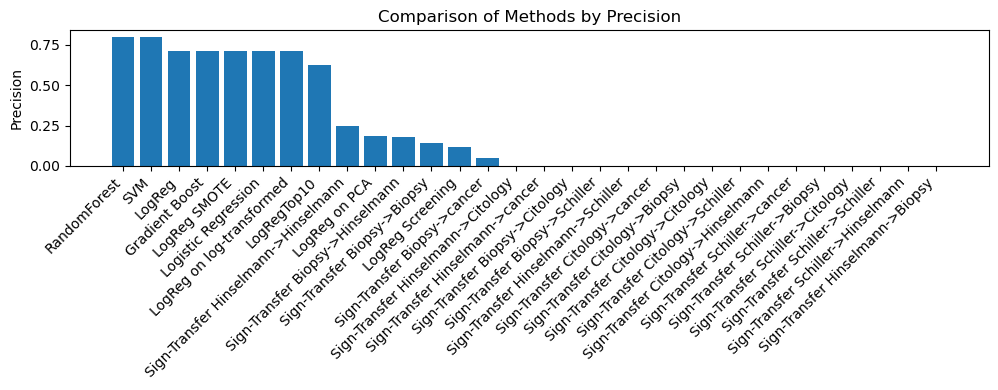

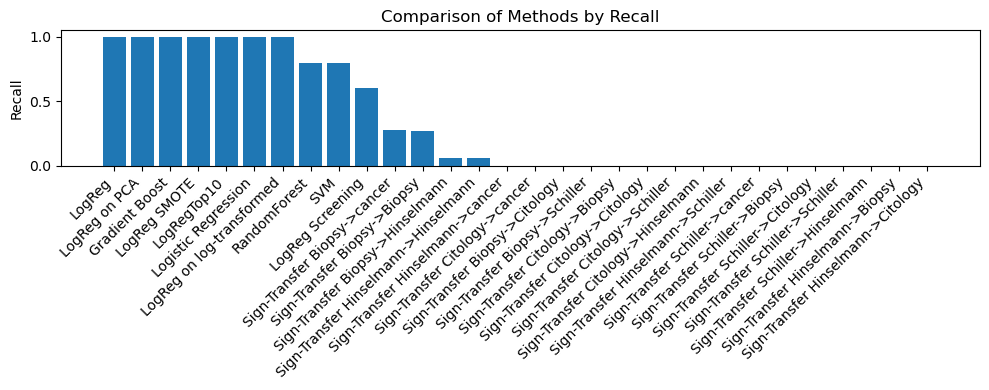

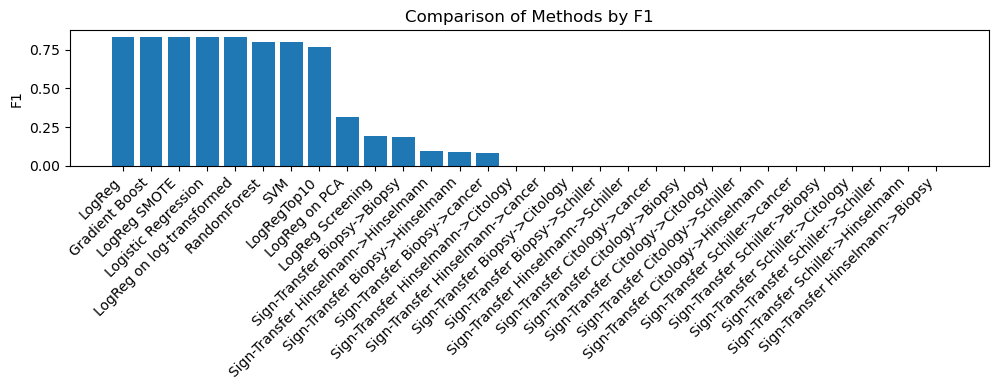

In [149]:
metrics = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1']
results_df = pd.DataFrame(results)

# --- Plot each metric separately, sorted by that metric ---
for metric in metrics:
    results_df_sorted = results_df.sort_values(by=metric, ascending=False)

    plt.figure(figsize=(10, 4))
    plt.bar(results_df_sorted['method'], results_df_sorted[metric])
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(metric)
    plt.title(f'Comparison of Methods by {metric}')
    plt.tight_layout()
    plt.show()
